In [27]:
# Author: Jaehun Kim
# Email: rlawogns1204@unist.ac.kr
# Affiliation: UNIST BME BCILAB
# Date: 2023-06-12
#
# This code implements a tactile information processing model using a spiking
# neural network (SNN). It simulates the processing of tactile information from
# mechanoreceptors in the skin through primary afferent fibers (PA), cuneate nucleus
# neurons (PN and IN), and ultimately, somatosensory cortex neurons. The model
# incorporates lateral inhibition and various receptive field properties to
# represent a realistic processing of touch stimuli.

# with DIGIT-sensor
# pip install torch==1.8.1+cu101 torchvision==0.9.1+cu101 torchaudio==0.8.1 -f https://download.pytorch.org/whl/torch_stable.html
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import scipy.io
import time
import numpy as np
from PIL import Image
import io
import datetime
import cv2
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score

from Function.snn_IZHIlayers import *
from Function.snn_plot import *
from Function.snn_simulation import *
from Function.snn_stimulation import *
from Function.snn_receptive_field_weights import *

from line_profiler import LineProfiler

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
# Check if GPU is available and print the CUDA version
print(f"GPU available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
# Enable GPU support if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Set the device to 'cpu'
device = 'cpu'
print(f"Using device: {device}")
# Start of the SNN (Spiking Neural Network) code

GPU available: True
CUDA version: 10.1
Using device: cpu


In [29]:
# Set sensor dimensions (height and width in millimeters)
sensor_h, sensor_w = 19, 16
# Set pixel dimensions (number of pixels in height and width)
# pixel_h, pixel_w = 320, 240///
pixel_h, pixel_w = 64,48
# Set image frames per second (FPS) of tactile sensor
image_FPS = 60

In [30]:
R = ReceptiveFieldWeights(pixel_h, pixel_w, device, type_output='multi')


torch.Size([88, 3072])
sa_rf shape: torch.Size([88, 3072]) with height = 11 with width = 8
ra_rf shape: torch.Size([130, 3072]) with height = 13 with width = 10
sa_cn_pn_rf shape:  torch.Size([54, 88]) sa_cn_pn_step_height: 9 sa_cn_pn_step_width: 6
sa_cn_in_rf shape:  torch.Size([54, 88]) sa_cn_in_step_height: 9 sa_cn_in_step_width: 6
ra_cn_pn_rf shape:  torch.Size([88, 130]) ra_cn_pn_step_height: 11 ra_cn_pn_step_width: 8
ra_cn_in_rf shape:  torch.Size([88, 130]) ra_cn_in_step_height: 11 ra_cn_in_step_width: 8
sa_intopn_rf shape:  torch.Size([54, 54])
ra_intopn_rf shape:  torch.Size([88, 88])
cn_pn_sa_rf shape:  torch.Size([112, 54]) cn_pn_sa_rf_step_height: 7 cn_pn_sa_rf_step_width: 4
cn_in_sa_rf shape:  torch.Size([112, 54]) cn_in_sa_rf_step_height: 7 cn_in_sa_rf_step_width: 4
cn_pn_ra_rf shape:  torch.Size([112, 88]) cn_pn_ra_rf_step_height: 7 cn_pn_ra_rf_step_width: 4
cn_in_ra_rf shape:  torch.Size([112, 88]) cn_in_ra_rf_step_height: 7 cn_in_ra_rf_step_width: 4
cn_intopn_rf shape:

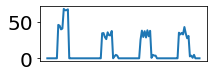

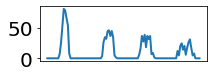

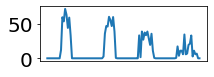

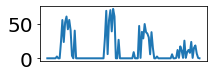

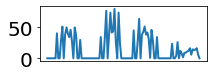

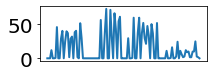

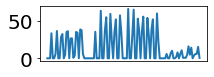

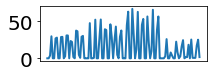

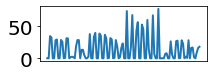

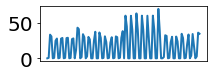

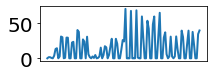

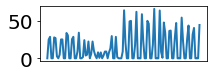

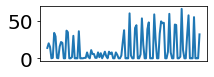

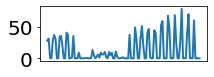

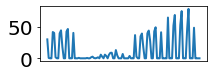

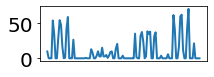

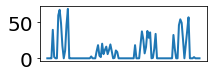

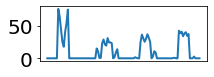

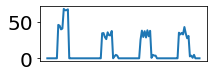

In [31]:
num_stim = 1000
F = 10
pixel_h = 64
pixel_w = 48
device = 'cpu'  # Or your device of choice

# Create a dictionary to store the stimuli
stimuli = {}

# Generate the stimuli for each angle from 0 to 180 degrees
for angle in range(0, 181, 10):
    # Generate the stimulus
    stimulus = generate_stimuli(angle, num_stim, pixel_h, pixel_w, F=F, plot_stimuli=False, device=device)
    
    # Add the stimulus to the dictionary
    stimuli[angle] = stimulus

    S = SNN(R, device = device, noise_std_val = 0)
    S.feedforward(stimulus)

    mean_firing_rates = plot_SNN(S)



In [32]:
num_trials = 20
num_angles = 181
num_stim = 1000
F = 10
pixel_h = 64
pixel_w = 48
device = 'cpu'  # Or your device of choice
data = []
labels = []

# Run the trials
for trial in range(num_trials):
    # Generate the stimuli for each angle from 0 to 180 degrees
    for angle in range(0, num_angles, 10):
        # Generate the stimulus
        stimulus = generate_stimuli(angle, num_stim, pixel_h, pixel_w, F=F, plot_stimuli=False, device=device)
        
        S = SNN(R, device = device, noise_std_val = 0)
        S.feedforward(stimulus)
        mean_firing_rates = plot_SNN(S,plot_figure = False)

        # Save the data and labels
        data.append(mean_firing_rates.cpu().numpy())
        labels.append(angle)


In [43]:
# Convert data and labels to numpy arrays
data = np.array(data)
labels = np.array(labels)

np.save('data_svm.npy', data)
np.save('labels_svm.npy', labels)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Create and train the SVM
clf = svm.SVC(kernel='linear')  # You can change the kernel as needed
clf.fit(X_train, y_train)

# Test the SVM
y_pred = clf.predict(X_test)

# Print the accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

print(X_train.shape)
print(X_test.shape)
print(y_train)
print(y_test)

Accuracy: 0.9078947368421053
(304, 112)
(76, 112)
[ 10 110 120 180 130   0 160 120 140 180 170 170 160  90  60  70  40  30
 130  80 140 100 100 160  30  20  10  60   0 120 170  90  50  40  90  90
  60 150 110 180 140  40 140 110 100 110  50  60 130   0  30  30 180  70
  60 170 150 140 100 110  20 160   0  60 100 180 100  60  80  50  80 130
  20   0 170  10 130  50 140  20 160 120  90  10 100  20  20  50 110  40
 180 110  80 100  10  80 120 150  90 110 130  90 100 170  80 160  30  10
 120 110  20  50 120 150   0 110  80 140   0 170  80  60  60  30  70  40
  60 180 120  50  30  20  90  70 110  20 140  10 120 100  70  60  50 150
 130  30 130 170  10 100  70 130 120  10  90   0 130  90  60 170  80 150
  90 150 130  70 120 160  90 180  90 160   0 170   0 120 170   0 110 130
 120 170  30  70  30  50 160  70 100  40  90 160  50 170  10  40   0  30
  60  40  90 130  10 100 140  80   0  20 130 100 180  50  50  20 140  80
  70 140  40  20  50 150  70 130  40  80 170  30 100  30  40  90  40 180
 